# Title
[]()

In [1]:
import requests
import json
from pandas import json_normalize  
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *
from custom_nlp import *
import pickle
import os

In [20]:
with open("credentials.json") as f:
    credentials = json.load(f)

In [18]:
with open("credentials_long_lived.json") as f2:
    ll_credentials = json.load(f2)

# `get_user_ig_post_text`

In [8]:

def get_user_ig_post_text(ig_user_id, access_token, pages=5, filename=None,
    json_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\raw',
    csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'):
    """ SH 2023-01-25 23:18 Modify so it won't pull duplicate pages
    Pull the media from a given Instagram account.

    Parameters:
        - ig_user_id: Can be obtained from Facebook Graph API explorer using this query 
            (requires business_management permission, possibly others also): 
             me/accounts?fields=instagram_business_account{id,name,username,profile_picture_url}
        - access_token
        - pages: Number of pages of results to retrieve starting in reverse chronological order.
            Each page of results provides 25 posts.
        - filename (str): Filename (without extension) for saving the outputs. If None, outputs are not saved.
            For outputs to be saved, the custom functions save_csv and savepickle must be imported.
        - json_path and csv_path (raw string): path to which to save the json and dataframe outputs,
            respectively.
    
    Returns
        - df: DataFrame with the following information (1 post/reel per row)
            - caption
            - like count
            - comments count
            - top-level comments: If the amount of comments is high (>53 commments), it will provide the endpoints, 
                it will return additional endpoints for additional comments ('comments.paging.*').
            - media type: video or image
            - media product type: reels or feed
            - media URL (not available for all reels)
            - permalink
            - timestamp
            - post id
            - comments.data (list of dictionaries): timestamp, username, text, like count, and comment id.
            - thumbnail URL of videos
        - response_json: JSON object with each page number of results as the key (starting with 1)

    """
    user_id = str(ig_user_id)
    url_root = "https://graph.facebook.com/v15.0/"
    url_without_token = f'{url_root}{ig_user_id}/media?fields=timestamp%2Ccaption%2Clike_count%2Ccomments_count%2Cmedia_type%2Cmedia_product_type%2Cmedia_url%2Cpermalink%2Cid%2Cthumbnail_url%2Ccomments%7Btimestamp%2Ctext%2Cusername%2Clike_count%2Creplies%7Btimestamp%2Ctext%2Cusername%2Clike_count%7D%7D&access_token='
    url = url_without_token+access_token
    print(url_without_token)
    response_json_dict = dict()
    df_list = []
    for page in range(1,pages+1):
        response = requests.get(url)
        print(f'Requesting page {page}...')
        print('\tResponse status code: ',response.status_code)
        response_json_dict[page] = response.json()
        if response.status_code//100 != 2: # Stop the function if there is an error in the request
            print(response_json_dict[page]['error'])
            break
        try:
            df_list.append(json_normalize(response_json_dict[page], record_path='data'))
        except:
            print('No data in request response for page', page)
        try:
            next_endpoint = response_json_dict[page]['paging']['next']
            if next_endpoint+access_token != url:
                url = next_endpoint
            else:
                print('end')
                break
        except: 
            pass
    try:
        df = pd.concat(df_list)
        print('Number of posts:',len(df))
    except:
        df = response
    if filename:
        try:
            save_csv(df,filename,csv_path)
            savepickle(response_json_dict,filename,'sav',json_path)
        except:
            print('Unable to save outputs')
    return df, response_json_dict



# Load IG post data

In [4]:
filename='am_ig_posts_50pages_2023-01-26.csv'
csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'
df_am50 = load_csv(filename, csv_path, column1_as_index=True)

Dataframe shape:  (1250, 13)
Time completed: 2023-01-30 10:06:35.807927


# Process post data

In [6]:
def process_df_timestamp(input_df, timestamp_colum='timestamp'):
    """
    Convert dates in the json-derived dataframe from Facebook API read requests
    into different formats.

    Parameters: 
        - input_df : DataFrame with the timestamp of the data.
        - timestamp_column (str): Name of the column with the timestamp.
    """
    df = input_df.reset_index(drop=True)
    regex_date = r'.+T'
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['time'] = df['timestamp'].dt.time
    df['hour'] = df['timestamp'].dt.hour
    return df

## process text

### Version 1

In [17]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
def preprocess_post_text(doc):
    """
    Prepare data from text documents for NLP:
    - Remove all the special characters
    - Remove all single characters
    - Substitute multiple spaces with single space
    - Convert to lowercase

    Parameters:
    doc (string): Document.

    Returns: Processed doc.
    """
    wnl = WordNetLemmatizer()
    try:
        # Split text into single words (also gets rid of extra white spaces)
        words = word_tokenize(doc)

        # Convert to lower case
        words = [word.lower() for word in words]

        # Lemmatize words (must be done after conversion to lower case)
        words = [wnl.lemmatize(word) for word in words]
        
        # join words back together as a string
        words = ''.join([word+' ' for word in words])

        # Join @ and # to the subsequent word to retain handles and hashtags
        words = re.sub(r'@ \w+', 'zzzHandle', words)
        words = re.sub(r'# \w+', 'zzzHashtag', words)

        # Remove any URLs 
        words = re.sub(r'\w*\.+\w*', '', words) # Remove periods in middle of word
        words = re.sub(r'\w*/+\w*', '', words) # remove forward slash in middle of word
        words = re.sub(r'\w*/+\w*', '', words)

        # Replace hypthens with spaces
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)

        # Remove numbers
        words = re.sub(r'\d:\d\d[\-a-zA-Z]*','zzzTime', words) # Time of day
        words = re.sub(r'\b\d+\b', 'zzzNumber', words)
        words = re.sub(r'\b\d+\w+\b', 'zzzNumber', words) #Number with letters

        # remove special characters
        non_hashtag_punctuation = ''.join([char for char in string.punctuation if char not in '#@'])
        words = ''.join([char for char in words if char not in non_hashtag_punctuation])

        return words
    except: # In case value is nan
        return 'zzzEmpty'

from sklearn.feature_extraction.text import CountVectorizer
from custom_nlp import *
def post_preprocessing(input_df, text_column='caption', n_top_to_print=10, **kwargs):
    df = process_df_timestamp(input_df)
    df[text_column] = df[text_column].apply(lambda x: preprocess_post_text(x))

    # kwargs
    stop_words = kwargs.get('stop_words', 'english')
    token_pattern = kwargs.get('token_pattern', r"(?u)\b\w\w+\b")
    ngram_range = kwargs.get('ngram_range', (1,1))
    max_df = kwargs.get('max_df', 1.0)
    min_df = kwargs.get('min_df', 2)
    max_features = kwargs.get('max_features', None)
    
    print('Token pattern:', token_pattern)

    vect = CountVectorizer(
            stop_words=stop_words, 
            token_pattern=token_pattern,
            ngram_range=ngram_range,
            max_df=max_df,
            min_df=min_df,
            max_features=max_features
        )

    vect.fit(df['caption'])
    vector = vect.transform(df['caption'])
    print('Shape of vector array: ', vector.shape)
    vector_df = pd.DataFrame(vector.toarray(), columns=vect.get_feature_names_out())

    # Replace zzz tags with brackets 
    vector_df.columns = vector_df.columns.str.replace(r'zzz(\w+)', r'<\1>', regex=True)
    df['caption'] = df['caption'].apply(lambda x: re.sub(r'zzz(\w+)', r'<\1>', x))
    print(f'\nTop {n_top_to_print} words:')
    print(vector_df.sum().sort_values(ascending=False).head(n_top_to_print))
    print('Time processed:', datetime.now())

    return df, vector_df

df, vector_df = post_preprocessing(df_am50.head(), max_features=1000)

Token pattern: (?u)\b\w\w+\b
Shape of vector array:  (5, 20)

Top 10 words:
<hashtag>    26
<number>      8
muscle        6
body          5
thing         3
ha            3
health        3
week          3
video         3
love          3
dtype: int64
Time processed: 2023-01-27 21:14:51.316057


In [19]:
df_am_processed, count_vector_am = post_preprocessing(df_am50, max_features=1000)
count_vector_am

Token pattern: (?u)\b\w\w+\b
Shape of vector array:  (1250, 1000)

Top 10 words:
<hashtag>    4694
<number>     2393
nt           1168
wa            844
time          687
people        612
body          593
week          560
want          558
ve            553
dtype: int64
Time processed: 2023-01-27 21:15:24.993011


,ab,able,absolute,absolutely,account,accountability,accountable,achieve,achieved,achieving,...,<handle>,<hashtag>,<number>,<numberzzznumber>,𝐢𝐬,𝐨𝐟,𝐭𝐨,𝐲𝐨𝐮,𝐲𝐨𝐮𝐫,𝗵𝗼𝗽𝗲
0,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,10,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,8,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,0,0,0,0,0,0,0,0,...,0,11,1,0,0,0,0,0,0,0
1246,0,0,0,0,0,0,0,0,0,0,...,0,11,1,0,0,0,0,0,0,0
1247,0,0,0,0,0,0,0,0,0,0,...,0,9,2,0,0,0,0,0,0,0
1248,0,0,0,0,0,0,0,0,0,0,...,0,11,3,0,0,0,0,0,0,0


In [13]:
[word+f': {sum}' for sum, word in zip(count_vector_am.sum(), count_vector_am.columns)]

['ab: 65',
 'able: 96',
 'absolute: 24',
 'absolutely: 89',
 'account: 19',
 'accountability: 38',
 'accountable: 13',
 'achieve: 115',
 'achieved: 27',
 'achieving: 24',
 'acid: 16',
 'action: 22',
 'active: 27',
 'activity: 26',
 'actually: 228',
 'add: 88',
 'added: 25',
 'adding: 19',
 'advice: 46',
 'advocate: 17',
 'aesthetic: 38',
 'affect: 24',
 'afraid: 26',
 'age: 30',
 'ago: 65',
 'agree: 15',
 'alcohol: 74',
 'allow: 14',
 'alternative: 15',
 'amanda: 160',
 'amazing: 102',
 'animal: 13',
 'answer: 33',
 'anti: 15',
 'anymore: 17',
 'apart: 17',
 'appearance: 13',
 'appreciate: 24',
 'approach: 44',
 'area: 38',
 'ask: 51',
 'asked: 37',
 'aspect: 14',
 'asset: 15',
 'associated: 15',
 'ate: 27',
 'athlete: 66',
 'attention: 22',
 'attitude: 20',
 'austrailia: 25',
 'available: 20',
 'average: 15',
 'avoid: 18',
 'aware: 29',
 'away: 89',
 'awhile: 20',
 'bad: 86',
 'balance: 56',
 'balanced: 39',
 'ball: 14',
 'bar: 46',
 'based: 92',
 'basic: 16',
 'basis: 22',
 'beautifu

In [33]:
# Need to deal with formatted text, which is being considered as different words
df_am_processed.loc[4,'caption']


'𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞 creatine is one of the most vastly researched supplement and ha been promoted in the fitness industry in the last few year  according to research  supplementation with creatine monohydrate ha been shown to increase skeletal muscle mass  lean body mass and muscle fibre size  research also suggests past this and it may encourage healthy aging and benefit brain health  𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞  creatine supplementation can be hugely beneficial for athletic performance and study have also showed it can have an impact on body composition  prolonged creatine ingestion inducing an increase in fat free mass   𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐭𝐨 𝐥𝐨𝐚𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞  nope  <Number> daily will suffice   the idea to saturate the muscle is just to experience benefit sooner   increase water consumption when you start taking creatine  𝐖𝐡𝐞𝐧 𝐬𝐡𝐨𝐮𝐥𝐝 𝐈 𝐭𝐚𝐤𝐞 𝐢𝐭  evidence doe suggest post workout is superior to pre workout  𝐀𝐫𝐞 𝐭𝐡𝐞𝐫𝐞 𝐚𝐧𝐲 𝐬𝐢𝐝𝐞 𝐞𝐟𝐟𝐞𝐜𝐭𝐬   bloating  this is due to the muscle absorbing the water with the creatine  very

In [31]:
import unicodedata

unistr = df_am_processed.loc[4,'caption']
form = 'NFKD'
unicodedata.normalize(form, unistr)

'Creatine creatine is one of the most vastly researched supplement and ha been promoted in the fitness industry in the last few year  according to research  supplementation with creatine monohydrate ha been shown to increase skeletal muscle mass  lean body mass and muscle fibre size  research also suggests past this and it may encourage healthy aging and benefit brain health  Do I need Creatine  creatine supplementation can be hugely beneficial for athletic performance and study have also showed it can have an impact on body composition  prolonged creatine ingestion inducing an increase in fat free mass   Do I need to load Creatine  nope  <Number> daily will suffice   the idea to saturate the muscle is just to experience benefit sooner   increase water consumption when you start taking creatine  When should I take it  evidence doe suggest post workout is superior to pre workout  Are there any side effects   bloating  this is due to the muscle absorbing the water with the creatine  very

In [37]:
# See what happens to emojis when using the unicodedata.normalize function
for index, value in df_am_processed.loc[4:5,'caption'].items():
    print(value,'\n')
    print(unicodedata.normalize('NFKD', value),'\n')

𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞 creatine is one of the most vastly researched supplement and ha been promoted in the fitness industry in the last few year  according to research  supplementation with creatine monohydrate ha been shown to increase skeletal muscle mass  lean body mass and muscle fibre size  research also suggests past this and it may encourage healthy aging and benefit brain health  𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞  creatine supplementation can be hugely beneficial for athletic performance and study have also showed it can have an impact on body composition  prolonged creatine ingestion inducing an increase in fat free mass   𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐭𝐨 𝐥𝐨𝐚𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞  nope  <Number> daily will suffice   the idea to saturate the muscle is just to experience benefit sooner   increase water consumption when you start taking creatine  𝐖𝐡𝐞𝐧 𝐬𝐡𝐨𝐮𝐥𝐝 𝐈 𝐭𝐚𝐤𝐞 𝐢𝐭  evidence doe suggest post workout is superior to pre workout  𝐀𝐫𝐞 𝐭𝐡𝐞𝐫𝐞 𝐚𝐧𝐲 𝐬𝐢𝐝𝐞 𝐞𝐟𝐟𝐞𝐜𝐭𝐬   bloating  this is due to the muscle absorbing the water with the creatine  very 

### Version 2
Remove text formatting. Retain contractions.

In [46]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import unicodedata
def preprocess_post_text(doc):
    """
    Prepare data from text documents for NLP:
    - Convert to lowercase
    - Remove formatting
    - Remove all the special characters
    - Remove all single characters
    - Substitute multiple spaces with single space

    Parameters:
    doc (string): Document.

    Returns: Processed doc.
    """
    wnl = WordNetLemmatizer()
    try:
        # Remove apostrophes before tokenization to preserve contractions like "should've"
        doc = re.sub(r"(\b\w+)'(\w+\b)", r'\1\2', doc)

        # Split text into single words (also gets rid of extra white spaces)
        words = word_tokenize(doc)

        # Remove text formatting
        words = [unicodedata.normalize('NFKD', word) for word in words]
        
        # Convert to lower case
        words = [word.lower() for word in words]

        # Lemmatize words (must be done after conversion to lower case)
        words = [wnl.lemmatize(word) for word in words]
        
        # join words back together as a string
        words = ''.join([word+' ' for word in words])

        # Join @ and # to the subsequent word to retain handles and hashtags
        words = re.sub(r'@ \w+', 'zzzHandle', words)
        words = re.sub(r'# \w+', 'zzzHashtag', words)

        # Remove any URLs 
        words = re.sub(r'\w*\.+\w*', '', words) # Remove periods in middle of word
        words = re.sub(r'\w*/+\w*', '', words) # remove forward slash in middle of word
        words = re.sub(r'\w*/+\w*', '', words)

        # Replace hypthens with spaces
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)

        # Remove numbers
        words = re.sub(r'\d:\d\d[\-a-zA-Z]*','zzzTime', words) # Time of day
        words = re.sub(r'\b\d+\b', 'zzzNumber', words)
        words = re.sub(r'\b\d+\w+\b', 'zzzNumber', words) #Number with letters

        # remove special characters
        non_hashtag_punctuation = ''.join([char for char in string.punctuation if char not in '#@'])
        words = ''.join([char for char in words if char not in non_hashtag_punctuation])

        return words
    except: # In case value is nan
        return 'zzzEmpty'

from sklearn.feature_extraction.text import CountVectorizer
from custom_nlp import *
def post_preprocessing(input_df, text_column='caption', n_top_to_print=10, **kwargs):
    df = process_df_timestamp(input_df)
    df[text_column] = df[text_column].apply(lambda x: preprocess_post_text(x))

    # kwargs
    stop_words = kwargs.get('stop_words', 'english')
    token_pattern = kwargs.get('token_pattern', r"(?u)\b\w\w+\b")
    ngram_range = kwargs.get('ngram_range', (1,1))
    max_df = kwargs.get('max_df', 1.0)
    min_df = kwargs.get('min_df', 2)
    max_features = kwargs.get('max_features', None)
    
    print('Token pattern:', token_pattern)

    vect = CountVectorizer(
            stop_words=stop_words, 
            token_pattern=token_pattern,
            ngram_range=ngram_range,
            max_df=max_df,
            min_df=min_df,
            max_features=max_features
        )

    vect.fit(df['caption'])
    vector = vect.transform(df['caption'])
    print('Shape of vector array: ', vector.shape)
    vector_df = pd.DataFrame(vector.toarray(), columns=vect.get_feature_names_out())

    # Replace zzz tags with brackets 
    vector_df.columns = vector_df.columns.str.replace(r'zzz(\w+)', r'<\1>', regex=True)
    df['caption'] = df['caption'].apply(lambda x: re.sub(r'zzz(\w+)', r'<\1>', x))
    print(f'\nTop {n_top_to_print} words:')
    print(vector_df.sum().sort_values(ascending=False).head(n_top_to_print))
    print('Time processed:', datetime.now())

    return df, vector_df

df_am_processed, count_vector_am = post_preprocessing(df_am50, max_features=1000)
[word+f': {sum}' for sum, word in zip(count_vector_am.sum(), count_vector_am.columns)]

Token pattern: (?u)\b\w\w+\b
Shape of vector array:  (1250, 1000)

Top 10 words:
<hashtag>    4694
<number>     2392
wa            798
time          697
im            658
people        615
body          606
want          572
week          564
food          551
dtype: int64
Time processed: 2023-01-27 22:12:39.870275


['ab: 65',
 'able: 96',
 'absolute: 24',
 'absolutely: 89',
 'account: 19',
 'accountability: 38',
 'accountable: 13',
 'achieve: 117',
 'achieved: 27',
 'achieving: 24',
 'acid: 16',
 'action: 22',
 'active: 28',
 'activity: 26',
 'actual: 13',
 'actually: 229',
 'add: 88',
 'added: 25',
 'adding: 19',
 'advice: 46',
 'advocate: 17',
 'aesthetic: 38',
 'affect: 24',
 'afraid: 26',
 'age: 30',
 'ago: 66',
 'agree: 15',
 'alcohol: 76',
 'allow: 14',
 'alternative: 15',
 'amanda: 155',
 'amazing: 103',
 'answer: 33',
 'anti: 15',
 'anymore: 17',
 'apart: 17',
 'appearance: 13',
 'appreciate: 24',
 'approach: 44',
 'area: 39',
 'arent: 18',
 'ask: 51',
 'asked: 37',
 'aspect: 14',
 'asset: 15',
 'associated: 15',
 'ate: 27',
 'athlete: 66',
 'attention: 23',
 'attitude: 20',
 'austrailia: 25',
 'available: 20',
 'average: 15',
 'avoid: 18',
 'aware: 29',
 'away: 89',
 'awhile: 20',
 'bad: 86',
 'balance: 55',
 'balanced: 39',
 'ball: 14',
 'bar: 46',
 'based: 92',
 'basic: 16',
 'basis: 2

In [45]:
text = "i should've done that aren't"
text = re.sub(r"(\b\w+)'(\w+\b)", r'\1\2', text)
word_tokenize(text)

['i', 'shouldve', 'done', 'that', 'arent']

In [47]:
# Save the files
csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'
save_csv(df_am_processed, 'am_ig_posts_50pages_2023-01-26_processed', csv_path)
save_csv(count_vector_am, 'count_vector_am_50pages_2023-01-26', csv_path)

File saved:  C:/Users/silvh/OneDrive/lighthouse/portfolio-projects/online-PT-social-media-NLP/data/interim/am_ig_posts_50pages_2023-01-26_processed.csv
File saved:  C:/Users/silvh/OneDrive/lighthouse/portfolio-projects/online-PT-social-media-NLP/data/interim/count_vector_am_50pages_2023-01-26.csv


## Load Data

In [7]:
csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'
df_am_processed = load_csv('am_ig_posts_50pages_2023-01-26_processed.csv', csv_path, column1_as_index=True)
count_vector_am = load_csv('count_vector_am_50pages_2023-01-26.csv', csv_path, column1_as_index=True)

Dataframe shape:  (1250, 19)
Time completed: 2023-01-28 17:45:26.738459
Dataframe shape:  (1250, 1000)
Time completed: 2023-01-28 17:45:26.879461


In [11]:
count_vector_am.head()

,ab,able,absolute,absolutely,account,accountability,accountable,achieve,achieved,achieving,...,youll,young,younger,youre,youve,zone,<handle>,<hashtag>,<number>,<numberzzznumber>
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,1,0


## Version 3

In [68]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import unicodedata
def preprocess_post_text(doc):
    """
    Prepare data from text documents for NLP:
    - Convert to lowercase
    - Remove formatting
    - Remove all the special characters
    - Remove all single characters
    - Substitute multiple spaces with single space

    Parameters:
    doc (string): Document.

    Returns: Processed doc.
    """
    wnl = WordNetLemmatizer()
    try:
        # Remove apostrophes before tokenization to preserve contractions like "should've"
        doc = re.sub(r"(\b\w+)'(\w+\b)", r'\1\2', doc)

        # Split text into single words (also gets rid of extra white spaces)
        words = word_tokenize(doc)

        # Remove text formatting
        words = [unicodedata.normalize('NFKD', word) for word in words]
        
        # Convert to lower case
        words = [word.lower() for word in words]

        # Lemmatize words (must be done after conversion to lower case)
        words = [wnl.lemmatize(word) for word in words]
        
        # join words back together as a string
        words = ''.join([word+' ' for word in words])

        # Join @ and # to the subsequent word to retain handles and hashtags
        words = re.sub(r'@ \w+', 'zzzHandle', words)
        words = re.sub(r'# (\w+)', r'zzzHashtag\1', words)

        # Remove any URLs 
        words = re.sub(r'\w*\.+\w*', '', words) # Remove periods in middle of word
        words = re.sub(r'\w*/+\w*', '', words) # remove forward slash in middle of word
        words = re.sub(r'\w*/+\w*', '', words)

        # Replace hypthens with spaces
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)
        words = re.sub(r'(\w+)-(\w+)*', r'\1 \2', words)

        # Remove numbers
        words = re.sub(r'\d:\d\d[\-a-zA-Z]*','zzzTime', words) # Time of day
        words = re.sub(r'\b\d+\b', 'zzzNumber', words)
        words = re.sub(r'\b\d+\w+\b', 'zzzNumber', words) #Number with letters

        # remove special characters
        non_hashtag_punctuation = ''.join([char for char in string.punctuation if char not in '#@'])
        words = ''.join([char for char in words if char not in non_hashtag_punctuation])

        return words
    except: # In case value is nan
        return 'zzzEmpty'

from sklearn.feature_extraction.text import CountVectorizer
from custom_nlp import *
def post_preprocessing(input_df, text_column='caption', n_top_to_print=10, **kwargs):
    df = process_df_timestamp(input_df)
    df[text_column] = df[text_column].apply(lambda x: preprocess_post_text(x))

    # kwargs
    stop_words = kwargs.get('stop_words', 'english')
    token_pattern = kwargs.get('token_pattern', r"(?u)\b\w\w+\b")
    ngram_range = kwargs.get('ngram_range', (1,1))
    max_df = kwargs.get('max_df', 1.0)
    min_df = kwargs.get('min_df', 2)
    max_features = kwargs.get('max_features', None)
    
    print('Token pattern:', token_pattern)

    vect = CountVectorizer(
            stop_words=stop_words, 
            token_pattern=token_pattern,
            ngram_range=ngram_range,
            max_df=max_df,
            min_df=min_df,
            max_features=max_features
        )

    vect.fit(df['caption'])
    vector = vect.transform(df['caption'])
    print('Shape of vector array: ', vector.shape)
    vector_df = pd.DataFrame(vector.toarray(), columns=vect.get_feature_names_out())

    # Replace zzz tags with brackets 
    vector_df.columns = vector_df.columns.str.replace(r'zzzhashtag(\w+)', r'#\1', regex=True)
    vector_df.columns = vector_df.columns.str.replace(r'zzz(\w+)', r'<\1>', regex=True)
    df['caption'] = df['caption'].apply(lambda x: re.sub(r'zzzHashtag(\w+)', r'#\1', x))
    df['caption'] = df['caption'].apply(lambda x: re.sub(r'zzz(\w+)', r'<\1>', x))
    print(f'\nTop {n_top_to_print} words:')
    print(vector_df.sum().sort_values(ascending=False).head(n_top_to_print))
    print('Time processed:', datetime.now())

    return df, vector_df

df_am_processed, count_vector_am = post_preprocessing(df_am50, max_features=1000)

Token pattern: (?u)\b\w\w+\b
Shape of vector array:  (1250, 1000)

Top 10 words:
<number>    2392
wa           798
time         697
im           658
people       615
body         606
want         572
week         564
food         551
dont         547
dtype: int64
Time processed: 2023-01-30 10:32:23.135179


In [69]:
df_am50.head().loc[4,'caption']

'𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞\nCreatine is one of the most vastly researched supplements and has been promoted in the fitness industry in the last few years. According to research, supplementation with creatine monohydrate has been shown to increase Skeletal muscle mass, lean body mass and muscle fibre size. Research also suggests past this and it may encourage healthy aging and benefit brain health. \n\n𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞?\nCreatine supplementation can be hugely beneficial for athletic performance and studies have also showed it can have an impact on body composition (prolonged creatine ingestion inducing an increase in fat free mass). \n\n𝐃𝐨 𝐈 𝐧𝐞𝐞𝐝 𝐭𝐨 𝐥𝐨𝐚𝐝 𝐂𝐫𝐞𝐚𝐭𝐢𝐧𝐞?\nNope. 5g daily will suffice. (The idea to saturate the muscle is just to experience benefits sooner).\nIncrease water consumption when you start taking creatine.\n\n𝐖𝐡𝐞𝐧 𝐬𝐡𝐨𝐮𝐥𝐝 𝐈 𝐭𝐚𝐤𝐞 𝐢𝐭?\nEvidence does suggest post workout is superior to pre workout. \n\n𝐀𝐫𝐞 𝐭𝐡𝐞𝐫𝐞 𝐚𝐧𝐲 𝐬𝐢𝐝𝐞 𝐞𝐟𝐟𝐞𝐜𝐭𝐬?\n- Bloating - This is due to the muscles absorbing the wat

In [70]:
df_am_processed.loc[4,'caption']

'creatine creatine is one of the most vastly researched supplement and ha been promoted in the fitness industry in the last few year  according to research  supplementation with creatine monohydrate ha been shown to increase skeletal muscle mass  lean body mass and muscle fibre size  research also suggests past this and it may encourage healthy aging and benefit brain health  do i need creatine  creatine supplementation can be hugely beneficial for athletic performance and study have also showed it can have an impact on body composition  prolonged creatine ingestion inducing an increase in fat free mass   do i need to load creatine  nope  <Number> daily will suffice   the idea to saturate the muscle is just to experience benefit sooner   increase water consumption when you start taking creatine  when should i take it  evidence doe suggest post workout is superior to pre workout  are there any side effect   bloating  this is due to the muscle absorbing the water with the creatine  very 

In [71]:
count_vector_am.filter(regex='<')

,<handle>,<number>,<numberzzznumber>
0,0,5,0
1,0,2,0
2,0,0,0
3,0,0,0
4,0,1,0
...,...,...,...
1245,0,1,0
1246,0,1,0
1247,0,2,0
1248,0,3,0


In [72]:
count_vector_am.columns

Index(['ab', 'able', 'absolute', 'absolutely', 'account', 'accountability',
       'achieve', 'achieved', 'achieving', 'acid',
       ...
       '#onlinefitnesscoach', '#realnutrition', '#realresults', '#smile',
       '#strength', '#strengthtraining', '#strongwomen', '#travel', '<number>',
       '<numberzzznumber>'],
      dtype='object', length=1000)

In [73]:
# Save the files
csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'
save_csv(df_am_processed, 'am_ig_posts_50pages_2023-01-26_processed', csv_path)
save_csv(count_vector_am, 'count_vector_am_50pages_2023-01-26', csv_path)

File saved:  C:/Users/silvh/OneDrive/lighthouse/portfolio-projects/online-PT-social-media-NLP/data/interim/am_ig_posts_50pages_2023-01-26_processed.csv
Time completed: 2023-01-30 10:34:25.679323
File saved:  C:/Users/silvh/OneDrive/lighthouse/portfolio-projects/online-PT-social-media-NLP/data/interim/count_vector_am_50pages_2023-01-26.csv
Time completed: 2023-01-30 10:34:25.893324


## Process my posts

In [75]:
filename='my_ig_posts_50pages_2023-01-26.csv'
path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'
df_me50 = load_csv(filename, path, column1_as_index=True)

Dataframe shape:  (730, 11)
Time completed: 2023-01-30 10:37:44.792097


In [76]:
df_me_processed, count_vector_me = post_preprocessing(df_me50, max_features=1000)

Token pattern: (?u)\b\w\w+\b
Shape of vector array:  (730, 1000)

Top 10 words:
<number>            1407
help                 390
#yvr                 377
time                 375
#vancouver           374
#fitness             366
exercise             359
#nutrition           340
#personaltrainer     326
want                 311
dtype: int64
Time processed: 2023-01-30 10:38:30.265270


# EDA

Time completed: 2023-01-30 11:57:19.170392


wa        798
time      697
im        658
people    615
body      606
want      572
week      564
food      551
dont      547
just      535
dtype: int64

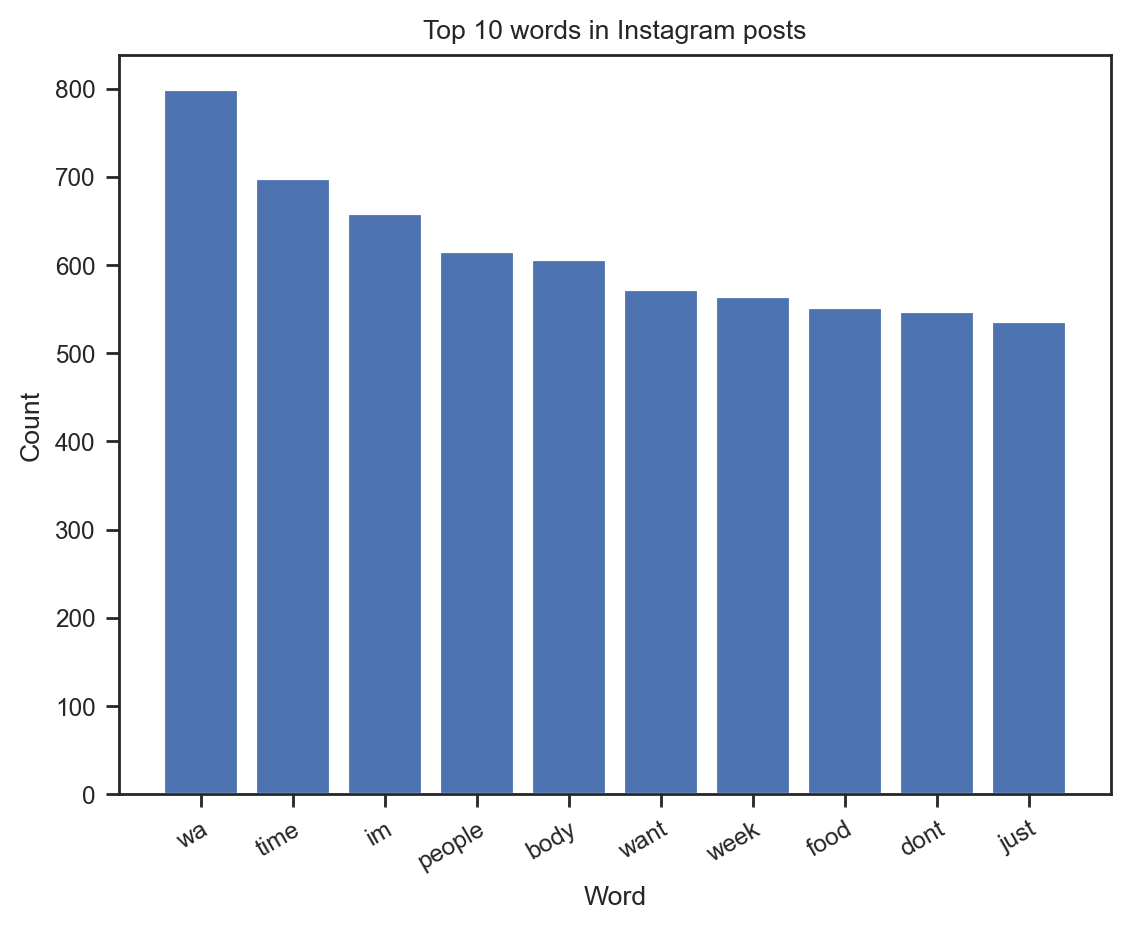

In [154]:
import seaborn as sns
import matplotlib_inline.backend_inline

def BoW_eda(df, n=30, text_column='caption', drop=['<number>'], context='paper', 
    filename=None, path=r'C:\Users\silvh\OneDrive\data science job search\content'):
    sns.reset_defaults()    
    %matplotlib inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
    plt.rcParams['savefig.dpi'] = 300
    
    sns.set_theme(context=context, style='ticks')
    df = df.drop(columns=drop)
    top_n = df.sum().sort_values(ascending=False).head(n)
    # ax = sns.barplot(df[top_n.index.tolist()], estimator='sum',errorbar=None) # this works but gives deprecated warning
    fig, ax = plt.subplots()
    ax.bar(top_n.index, top_n)
    ax.set_xticks(top_n.index) # This line suppresses the warning "UserWarning: FixedFormatter should only be used together with FixedLocator"
    ax.set_xticklabels(top_n.index, rotation=30, ha='right', rotation_mode='anchor')
    ax.set(ylabel='Count', xlabel='Word', title=f'Top {n} words in Instagram posts')
    ax.axis('tight')
    if filename:
        try:
            path = f'{path}/'.replace('\\','/')
            fig.savefig(path+filename, bbox_inches='tight')
            print('Saved: ', path+filename)
        except:
            print('Unable to save outputs')
    print('Time completed:', datetime.now())

    return top_n

BoW_eda(count_vector_am, n=10)

Saved:  C:/Users/silvh/OneDrive/data science job search/content/instagram BoW2.png
Time completed: 2023-01-30 11:58:07.026698


help                390
#yvr                377
time                375
#vancouver          374
#fitness            366
exercise            359
#nutrition          340
#personaltrainer    326
want                311
body                293
#nutritioncoach     283
feel                266
<handle>            258
work                249
day                 237
people              213
just                212
comment             205
training            196
food                196
make                192
shoulder            189
wa                  184
eating              178
goal                174
dtype: int64

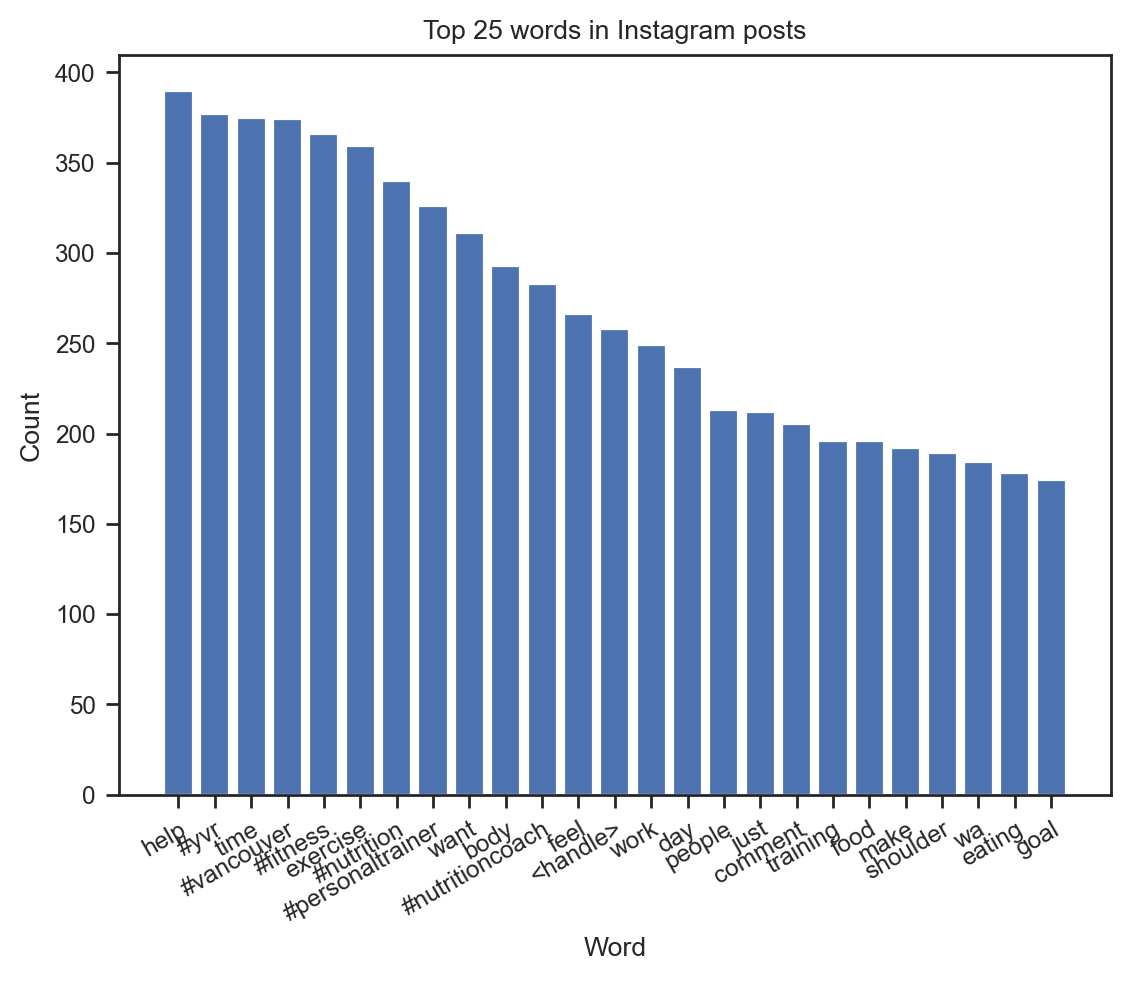

In [155]:
BoW_eda(count_vector_me, n=25, filename='instagram BoW2.png')

# Update `get_user_ig_post_text`

In [2]:
datetime.timestamp(datetime.now())

1675918834.99752

In [5]:
datetime.timestamp(datetime(2023,1,1))

1672560000.0

In [6]:
datetime.timestamp(datetime(2023,1,31))

1675152000.0

In [13]:
from datetime import datetime
datetime.timestamp(datetime.strptime('2023-01-31', "%Y-%m-%d"))

1675152000.0

In [21]:

def get_user_ig_post_text(ig_user_id, access_token, pages=5, since=None, until=None,
    filename=None,
    json_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\raw',
    csv_path=r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\online-PT-social-media-NLP\data\interim'):
    """ SH 2023-02-08 21:04 Modify so it can take date paramters
    Pull the media from a given Instagram account.

    Parameters:
        - ig_user_id: Can be obtained from Facebook Graph API explorer using this query 
            (requires business_management permission, possibly others also): 
             me/accounts?fields=instagram_business_account{id,name,username,profile_picture_url}
        - access_token
        - pages: Number of pages of results to retrieve starting in reverse chronological order.
            Each page of results provides 25 posts.
        - since and until (str): Date in 'yyyy-mm-dd format', e.g. '2023-01-01'
        - filename (str): Filename (without extension) for saving the outputs. If None, outputs are not saved.
            For outputs to be saved, the custom functions save_csv and savepickle must be imported.
        - json_path and csv_path (raw string): path to which to save the json and dataframe outputs,
            respectively.
    
    Returns
        - df: DataFrame with the following information (1 post/reel per row)
            - caption
            - like count
            - comments count
            - top-level comments: If the amount of comments is high (>53 commments), it will provide the endpoints, 
                it will return additional endpoints for additional comments ('comments.paging.*').
            - media type: video or image
            - media product type: reels or feed
            - media URL (not available for all reels)
            - permalink
            - timestamp
            - post id
            - comments.data (list of dictionaries): timestamp, username, text, like count, and comment id.
            - thumbnail URL of videos
        - response_json: JSON object with each page number of results as the key (starting with 1)
    Example syntax:
        df2022, response_json2022 = get_user_ig_post_text(credentials['ig_user_id'], credentials['access_token'],
        pages=50, since='2022-01-01', until='2022-12-31', filename='my_ig_posts_2022')

    """
    user_id = str(ig_user_id)
    url_root = "https://graph.facebook.com/v15.0/"
    url_without_token = f'{url_root}{ig_user_id}/media?fields=timestamp%2Ccaption%2Clike_count%2Ccomments_count%2Cmedia_type%2Cmedia_product_type%2Cmedia_url%2Cpermalink%2Cid%2Cthumbnail_url%2Ccomments%7Btimestamp%2Ctext%2Cusername%2Clike_count%2Creplies%7Btimestamp%2Ctext%2Cusername%2Clike_count%7D%7D'
    if since:
        url_without_token += f'&since={datetime.timestamp(datetime.strptime(since, "%Y-%m-%d"))}'
    if until:
        url_without_token += f'&until={datetime.timestamp(datetime.strptime(until, "%Y-%m-%d"))}'

    url = url_without_token+'&access_token='+access_token
    
    print(url_without_token)
    response_json_dict = dict()
    df_list = []
    for page in range(1,pages+1):
        response = requests.get(url)
        print(f'Requesting page {page}...')
        print('\tResponse status code: ',response.status_code)
        response_json_dict[page] = response.json()
        if response.status_code//100 != 2: # Stop the function if there is an error in the request
            print(response_json_dict[page]['error'])
            break
        try:
            df_list.append(json_normalize(response_json_dict[page], record_path='data'))
        except:
            print('No data in request response for page', page)
        try:
            next_endpoint = response_json_dict[page]['paging']['next']
            if next_endpoint+access_token != url:
                url = next_endpoint
            else:
                print('end')
                break
        except: 
            pass
    try:
        df = pd.concat(df_list)
        print('Number of posts:',len(df))
    except:
        df = response
    if filename:
        try:
            save_csv(df,filename,csv_path)
            savepickle(response_json_dict,filename,'sav',json_path)
        except:
            print('Unable to save outputs')
    return df, response_json_dict

df2022, response_json2022 = get_user_ig_post_text(credentials['ig_user_id'], credentials['access_token'],
        pages=50, since='2022-01-01', until='2022-12-31', filename='my_ig_posts_2022')

https://graph.facebook.com/v15.0/17841403231458630/media?fields=timestamp%2Ccaption%2Clike_count%2Ccomments_count%2Cmedia_type%2Cmedia_product_type%2Cmedia_url%2Cpermalink%2Cid%2Cthumbnail_url%2Ccomments%7Btimestamp%2Ctext%2Cusername%2Clike_count%2Creplies%7Btimestamp%2Ctext%2Cusername%2Clike_count%7D%7D&since=1641024000.0&until=1672473600.0
Requesting page 1...
	Response status code:  200
Requesting page 2...
	Response status code:  200
Requesting page 3...
	Response status code:  200
Requesting page 4...
	Response status code:  200
Requesting page 5...
	Response status code:  200
Requesting page 6...
	Response status code:  200
Requesting page 7...
	Response status code:  200
Requesting page 8...
	Response status code:  200
Requesting page 9...
	Response status code:  200
Requesting page 10...
	Response status code:  200
Requesting page 11...
	Response status code:  200
Requesting page 12...
	Response status code:  200
Requesting page 13...
	Response status code:  200
Requesting page

In [16]:

df_am50, response_json_am50 = get_user_ig_post_text(credentials['am_ig_user_id'], 
        credentials['am3_access_token'], pages=50, since='2018-10-01', until='2023-01-31',
        filename='am_ig_posts_50pages_2023-01-31')

https://graph.facebook.com/v15.0/17841401256046961/media?fields=timestamp%2Ccaption%2Clike_count%2Ccomments_count%2Cmedia_type%2Cmedia_product_type%2Cmedia_url%2Cpermalink%2Cid%2Cthumbnail_url%2Ccomments%7Btimestamp%2Ctext%2Cusername%2Clike_count%2Creplies%7Btimestamp%2Ctext%2Cusername%2Clike_count%7D%7D&since=1538377200.0&until=1675152000.0
Requesting page 1...
	Response status code:  400
{'message': 'Error validating access token: The session has been invalidated because the user changed their password or Facebook has changed the session for security reasons.', 'type': 'OAuthException', 'code': 190, 'error_subcode': 460, 'fbtrace_id': 'AQlg3gtsmP4ImtnfC_G8X05'}
Unable to save outputs


# *End of Page*